The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that.

In [54]:
import os
import pyspark
from pyspark.sql import SQLContext, SparkSession

# change "pierre.cs.colsotate.edu" to the name of your spark master node
SPARK_NODE="pierre.cs.colostate.edu"


# 31820 corresponds to SPARK_MASTER_PORT in $SPARK_HOME/conf/spark-env.sh
SPARK_PORT=31820

spark = SparkSession.builder.master('spark://{}:{}'.format(SPARK_NODE,SPARK_PORT)).appName('test').getOrCreate()

sqlContext = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)
print("Spark Version: " + spark.version)
print("PySpark Version: " + pyspark.__version__)

Spark Version: 3.0.3
PySpark Version: 3.0.3


In [129]:
#/FP/reviews.json

reviews = spark.read.json("/FP/tags.json")
reviews.show(n=25)

+----+--------------------+
|  id|                 tag|
+----+--------------------+
|  22|             aardman|
| 112|      secret service|
| 167|          hillarious|
| 270|           christian|
| 362|               mummy|
| 562|         pretentious|
| 648|                cool|
| 663|                 mtv|
| 758|       culture clash|
| 915|       gay character|
|1429|                rome|
|1485|francis ford copolla|
|1696|   private detective|
|1732|          historical|
|1739|           afterlife|
|1853|             rabbits|
|1992|                 war|
|2023|                bond|
|2117|               space|
|2145|   mistaken identity|
|2176|       relationships|
|2428|       nudity (rear)|
|2429|              biopic|
|2496|             tragedy|
|2543|               cute!|
+----+--------------------+
only showing top 25 rows



In [139]:
newColumns = ["tag_id","tag"]
modified = reviews.toDF(*newColumns)

In [128]:
tag_count = spark.read.json("/FP/tag_count.json")
tag_count.show()

+-------+---+------+
|item_id|num|tag_id|
+-------+---+------+
|      1|  4| 86963|
|      1|  1| 42940|
|      1| 26| 37116|
|      1|  1| 52206|
|      1| 21| 34442|
|      1| 91| 20919|
|      1|  1| 89954|
|      1| 14| 67843|
|      1|  1|104090|
|      1| 10| 55743|
|      1| 11| 87523|
|      1| 37|  6384|
|      1|  1| 51465|
|      1| 17| 59650|
|      1| 22| 77762|
|      1| 32| 37108|
|      1| 41| 24203|
|      1|  1| 95962|
|      1|  1| 29910|
|      1|  1|102837|
+-------+---+------+
only showing top 20 rows



In [200]:
combinedDF = tag_count.join(modified, ['tag_id'])

In [205]:
combinedDF.filter(combinedDF.num==combinedDF.agg({"num": "max"}).collect()[0][0]).show()

+------+-------+----+------+
|tag_id|item_id| num|   tag|
+------+-------+----+------+
| 16788|    260|1117|sci-fi|
+------+-------+----+------+



In [218]:
all_data = combinedDF.join(surveys, ['tag_id'])


In [224]:
all_data.show()

+------+-------+---+---+-------+-----+-------+
|tag_id|item_id|num|tag|item_id|score|user_id|
+------+-------+---+---+-------+-----+-------+
| 86963|      1|  4| 3d|   8961|    1| 921860|
| 86963|      1|  4| 3d|   4886|    1| 921860|
| 86963|      1|  4| 3d|  53435|    1| 921860|
| 86963|      1|  4| 3d|  68954|    5| 921860|
| 86963|      1|  4| 3d|      1|    1| 921860|
| 86963|      1|  4| 3d|   3793|    1| 921860|
| 86963|      1|  4| 3d|   8961|    3| 279494|
| 86963|      1|  4| 3d|  68954|    5| 279494|
| 86963|      1|  4| 3d|   2355|    4| 279494|
| 86963|      1|  4| 3d|  58803|   -1| 279494|
| 86963|      1|  4| 3d|      1|    4| 279494|
| 86963|      1|  4| 3d|  33679|    1| 279494|
| 86963|      1|  4| 3d|     97|    1| 704376|
| 86963|      1|  4| 3d|  59784|    3| 704376|
| 86963|      1|  4| 3d|   5218|    3| 704376|
| 86963|      1|  4| 3d|  64197|    1| 704376|
| 86963|      1|  4| 3d|  55995|    5| 704376|
| 86963|      1|  4| 3d|  66097|    2| 704376|
| 86963|     

In [234]:
joined = all_data.join(joinedDF, ['item_id'])

In [235]:
joined.show()

+-------+------+---+---------------+-------+-----+-------+---------+---------+-------------+-------+--------------------+--------------+------+-------+
|item_id|tag_id|num|            tag|item_id|score|user_id|avgRating|dateAdded|   directedBy| imdbId|            starring|         title|rating|user_id|
+-------+------+---+---------------+-------+-----+-------+---------+---------+-------------+-------+--------------------+--------------+------+-------+
|     26| 91212|  2|based on a play|   3030|   -1| 277637|  3.60747|     null|Oliver Parker|0114057|Kenneth Branagh, ...|Othello (1995)|   3.0| 501777|
|     26| 91212|  2|based on a play|   3030|   -1| 277637|  3.60747|     null|Oliver Parker|0114057|Kenneth Branagh, ...|Othello (1995)|   3.0| 797744|
|     26| 91212|  2|based on a play|   3030|   -1| 277637|  3.60747|     null|Oliver Parker|0114057|Kenneth Branagh, ...|Othello (1995)|   3.0| 257286|
|     26| 91212|  2|based on a play|   3030|   -1| 277637|  3.60747|     null|Oliver Par

In [244]:
#Minimum value of each group 

all_DF = all_data.groupby('tag').agg({'score': 'max', 'num' : 'max'}).toPandas()

In [246]:
all_DF.head()

,tag,max(score),max(num)
0,anime,5,203
1,1970s,5,34
2,travel,5,56
3,poetry,5,45
4,oscar,5,25


In [253]:
sorted_df = all_DF.sort_values(by='max(num)', ascending=False)[:15]

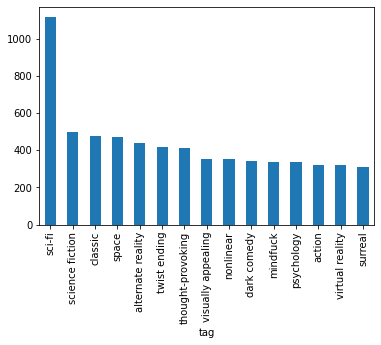

In [255]:
sorted_df.groupby('tag')['max(num)'].sum().sort_values(ascending=False).plot(kind='bar');

In [127]:
#survey_answers.json

surveys = spark.read.json("/FP/survey_answers.json")
surveys.show()

+-------+-----+------+-------+
|item_id|score|tag_id|user_id|
+-------+-----+------+-------+
|   3108|    3| 50126| 978707|
|   2858|    1| 50126| 978707|
|   1269|    1| 50126| 978707|
|   1136|    1| 50126| 978707|
|   1220|    1| 50126| 978707|
|   1212|    1| 50126| 978707|
|    849|    3| 52623| 978707|
|    592|    5| 52623| 978707|
|   6934|    5| 52623| 978707|
|   1580|    4| 52623| 978707|
|     10|    3| 52623| 978707|
|    434|    2| 52623| 978707|
|   2916|    5| 51703| 978707|
|     32|    5| 51703| 978707|
|   1240|    1| 51703| 978707|
|   3681|    1| 51703| 978707|
|    541|    1| 51703| 978707|
|   1209|    1| 51703| 978707|
|   2997|    2| 29527| 978707|
|    750|    5| 29527| 978707|
+-------+-----+------+-------+
only showing top 20 rows



In [55]:
ratings = spark.read.json("/FP/ratings.json")
ratings.show()

+-------+------+-------+
|item_id|rating|user_id|
+-------+------+-------+
|      5|   3.0| 997206|
|     10|   4.0| 997206|
|     13|   4.0| 997206|
|     17|   5.0| 997206|
|     21|   4.0| 997206|
|     28|   5.0| 997206|
|     31|   4.0| 997206|
|     39|   3.0| 997206|
|     40|   4.0| 997206|
|     45|   2.0| 997206|
|     46|   4.0| 997206|
|     50|   5.0| 997206|
|     62|   4.0| 997206|
|     74|   5.0| 997206|
|     85|   2.0| 997206|
|    110|   5.0| 997206|
|    112|   4.0| 997206|
|    141|   4.0| 997206|
|    150|   3.0| 997206|
|    161|   3.0| 997206|
+-------+------+-------+
only showing top 20 rows



In [56]:
print('Number of partitions for the ratings DataFrame: {}'.format(ratings.rdd.getNumPartitions()))

Number of partitions for the ratings DataFrame: 96


In [76]:
training, test = ratings.randomSplit(weights = [0.90, 0.10], seed = 13)

In [77]:
from pyspark.ml.recommendation import ALS

als = ALS(maxIter=5, regParam=0.01, rank = 2, userCol="user_id", itemCol="item_id", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

In [78]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.9011571792887859


In [79]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.9011571792887861


In [80]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)


# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

In [118]:
userRecs.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    148|[[117182, 69.1636...|
|    471|[[117182, 91.2949...|
|   1829|[[117182, 94.5355...|
|   1959|[[117182, 98.3329...|
|   2122|[[117182, 82.4464...|
|   3749|[[117182, 61.8627...|
|   3918|[[117182, 112.947...|
|   4101|[[117182, 102.416...|
|   4818|[[117182, 108.022...|
|   5518|[[117182, 84.7156...|
|   5803|[[117182, 82.0787...|
|   6336|[[197157, 83.0040...|
|   6397|[[117182, 87.4372...|
|   6466|[[117182, 96.6786...|
|   7253|[[117182, 122.741...|
|  10623|[[117182, 100.024...|
|  10817|[[117182, 79.9851...|
|  14450|[[117182, 125.085...|
|  14570|[[117182, 101.985...|
|  15619|[[117182, 109.009...|
+-------+--------------------+
only showing top 20 rows



In [114]:
userRecs.where(userRecs.user_id == 148).select("recommendations.item_id").collect()

[Row(item_id=[117182, 144144, 167102, 153644, 153977, 209455, 154206, 153204, 160702, 27673])]

In [121]:
movies_info.filter(movies_info.item_id == 117182).toPandas()

,avgRating,dateAdded,directedBy,imdbId,item_id,starring,title
0,3.16667,2014-11-17T22:26:06,Sharon Lockhart,1757733,117182,,Double Tide (2010)


In [13]:
movieRecs.where(movieRecs.item_id == 2).select("recommendations.user_id", "recommendations.rating").collect()

[Row(user_id=[277091, 256579, 622619, 934657, 686549, 404258, 655635, 17666, 179222, 181130], rating=[6.269768238067627, 5.970066070556641, 5.958440780639648, 5.917179107666016, 5.811573028564453, 5.789891719818115, 5.757927417755127, 5.713595867156982, 5.6522016525268555, 5.646612167358398])]

In [14]:
# Generate top 10 movie recommendations for a specified set of users
users = ratings.select(als.getUserCol()).distinct().limit(1)
userSubsetRecs = model.recommendForUserSubset(users, 10)
# Generate top 10 user recommendations for a specified set of movies
movies = ratings.select(als.getItemCol()).distinct().limit(1)
movieSubSetRecs = model.recommendForItemSubset(movies, 10)

In [15]:
users.show()

+-------+
|user_id|
+-------+
| 964213|
+-------+



In [16]:
# End of the Affair, The (1999)|
movies.show()

+-------+
|item_id|
+-------+
|    296|
+-------+



In [17]:
userSubsetRecs.select("recommendations.item_id", "recommendations.rating").collect()

[Row(item_id=[26549, 182521, 178501, 95159, 138400, 194480, 153002, 125982, 7699, 181853], rating=[13.904430389404297, 11.355958938598633, 10.820833206176758, 10.186515808105469, 9.753451347351074, 9.711426734924316, 9.087898254394531, 9.012482643127441, 8.897541046142578, 8.76358413696289])]

In [18]:
# Generate top 10 user recommendations for a specified movie (Pulp Fiction (1994))


movieSubSetRecs.select("recommendations.user_id", "recommendations.rating").collect()

[Row(user_id=[232209, 556618, 342386, 301480, 491579, 175243, 774093, 543561, 602858, 878366], rating=[9.360615730285645, 8.264141082763672, 8.1810941696167, 8.106060028076172, 8.076605796813965, 8.041015625, 7.968531131744385, 7.685000419616699, 7.645286560058594, 7.570684432983398])]

In [109]:
movieSubSetRecs.show()

+-------+--------------------+
|item_id|     recommendations|
+-------+--------------------+
|   3703|[[140975, 7.12631...|
+-------+--------------------+



In [20]:
movies_info = spark.read.json("/FP/metadata.json")
movies_info.show()

+---------+---------+--------------------+-------+-------+--------------------+--------------------+
|avgRating|dateAdded|          directedBy| imdbId|item_id|            starring|               title|
+---------+---------+--------------------+-------+-------+--------------------+--------------------+
|  3.89146|     null|       John Lasseter|0114709|      1|Tim Allen, Tom Ha...|    Toy Story (1995)|
|  3.26605|     null|        Joe Johnston|0113497|      2|Jonathan Hyde, Br...|      Jumanji (1995)|
|  3.17146|     null|       Howard Deutch|0113228|      3|Jack Lemmon, Walt...|Grumpier Old Men ...|
|  2.86824|     null|     Forest Whitaker|0114885|      4|Angela Bassett, L...|Waiting to Exhale...|
|   3.0762|     null|       Charles Shyer|0113041|      5|Steve Martin, Mar...|Father of the Bri...|
|  3.85549|     null|        Michael Mann|0113277|      6|Robert De Niro, A...|         Heat (1995)|
|  3.37244|     null|      Sydney Pollack|0114319|      7|Harrison Ford, Gr...|      Sabrin

In [45]:
joinedDF = movies_info.join(ratings, ['item_id'])

In [47]:
joinedDF.show()

+-------+---------+---------+-------------+-------+--------------------+--------------+------+-------+
|item_id|avgRating|dateAdded|   directedBy| imdbId|            starring|         title|rating|user_id|
+-------+---------+---------+-------------+-------+--------------------+--------------+------+-------+
|     26|  3.60747|     null|Oliver Parker|0114057|Kenneth Branagh, ...|Othello (1995)|   3.0| 230914|
|     26|  3.60747|     null|Oliver Parker|0114057|Kenneth Branagh, ...|Othello (1995)|   3.0| 661874|
|     26|  3.60747|     null|Oliver Parker|0114057|Kenneth Branagh, ...|Othello (1995)|   1.0| 605885|
|     26|  3.60747|     null|Oliver Parker|0114057|Kenneth Branagh, ...|Othello (1995)|   3.5| 644632|
|     26|  3.60747|     null|Oliver Parker|0114057|Kenneth Branagh, ...|Othello (1995)|   5.0| 897262|
|     26|  3.60747|     null|Oliver Parker|0114057|Kenneth Branagh, ...|Othello (1995)|   3.0|  78411|
|     26|  3.60747|     null|Oliver Parker|0114057|Kenneth Branagh, ...|O

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movies=pd.read_csv('ml-25m/movies.csv')
rates=pd.read_csv('ml-25m/ratings.csv')
links=pd.read_csv('ml-25m/links.csv')
tags=pd.read_csv('ml-25m/tags.csv')
genome_scores=pd.read_csv('ml-25m/genome-scores.csv')
genome_tags=pd.read_csv('ml-25m/genome-tags.csv')

In [15]:
rates.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [20]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
data = rates.merge(movies,on='movieId', how='left')

In [4]:
Average_ratings = pd.DataFrame(data.groupby('title')['rating'].mean())

In [5]:
Average_ratings.sort_values(by='rating', ascending=False).head(20)

,rating
title,
Full of Grace (2015),5.0
Geordie (1955),5.0
Garfield In Paradise (1986),5.0
Lost Woods (2012),5.0
Garfield in the Rough (1984),5.0
Lost Time (2014),5.0
Who Killed Chea Vichea? (2010),5.0
Lost Rivers (2013),5.0
Who Killed Johnny (2013),5.0


### good movies normally receive higher ratings

In [6]:
data.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 81491
Shawshank Redemption, The (1994)    81482
Pulp Fiction (1994)                 79672
Silence of the Lambs, The (1991)    74127
Matrix, The (1999)                  72674
Name: rating, dtype: int64

In [7]:
Average_ratings['rating_counts'] = pd.DataFrame(data.groupby('title')['rating'].count())

In [8]:
Average_ratings

,rating,rating_counts
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1
"""Great Performances"" Cats (1998)",2.896648,179
#1 Cheerleader Camp (2010),2.111111,9
#Captured (2017),3.750000,2
#Female Pleasure (2018),3.666667,3
...,...,...
…And the Fifth Horseman Is Fear (1965),3.250000,2
キサラギ (2007),3.250000,2
チェブラーシカ (2010),3.166667,9


In [9]:
data_movies = movies.merge(Average_ratings, left_on='title', right_on='title', how='left')

In [10]:
data_movies = data_movies.drop(['rating'], axis=1)

In [11]:
data_movies = data_movies.merge(rates,left_on='movieId', right_on='movieId', how='left')

In [12]:
features = data_movies.pivot_table(index='title', columns='userId', values='rating').fillna(0)
features.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,162532.0,162533.0,162534.0,162535.0,162536.0,162537.0,162538.0,162539.0,162540.0,162541.0
title,,,,,,,,,,,,,,,,,,,,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Great Performances"" Cats (1998)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#1 Cheerleader Camp (2010),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#Captured (2017),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#Female Pleasure (2018),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#from scipy.sparse import csr_matrix
#features_matrix = csr_matrix(features.values)   
#features_matrix

In [18]:
from sklearn.neighbors import NearestNeighbors   
model = NearestNeighbors(metric = "cosine", algorithm = 'brute')
model.fit(features.values)    

NearestNeighbors(algorithm='brute', metric='cosine')

In [19]:
# Taking a new movie at random
query_index = np.random.choice(features.shape[0])    # Collect 1 record
print(query_index)

37942


In [20]:
distances, indices = model.kneighbors(features.iloc[query_index,:].values.reshape(1, -1), n_neighbors=6)

In [21]:
# Print top 5 movie recommendations for a random movie along with the distances from original movie

for i in range(0, len(distances.flatten())):   
    if(i==0):
        print("Recommendations for {0}:\n".format(features.index[query_index]))    
    else:
        print("{0}: {1}, with distance of {2}:".format(i, features.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Purple Ball, The (Lilovyy shar) (1987):

1: Decision: Liquidation (2018), with distance of 0.3374305545539259:
2: Aladdin and His Magic Lamp (1967), with distance of 0.3374413909867475:
3: Caravaggio (2007), with distance of 0.3387549253315545:
4: Longitude (2000), with distance of 0.3397347176941904:
5: Совершенно серьезно (1961), with distance of 0.3483688807477888:


### Some random analysis

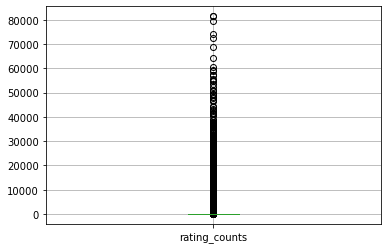

In [20]:
Average_ratings.boxplot(column=['rating_counts']);

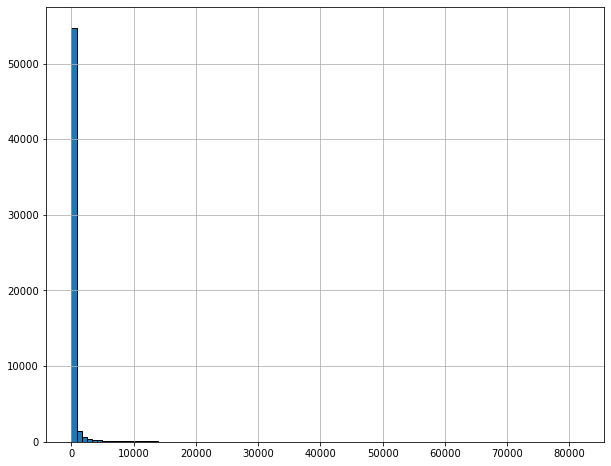

In [19]:
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
Average_ratings['rating_counts'].hist(bins=100);

<Figure size 720x576 with 0 Axes>

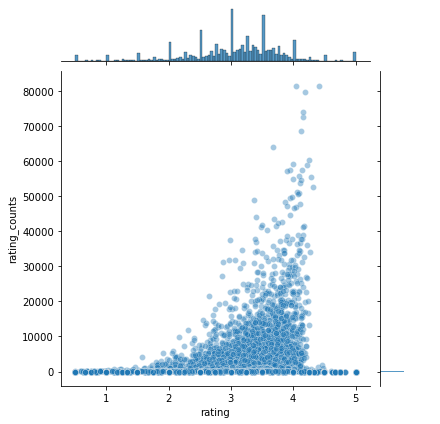

In [22]:
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=Average_ratings, alpha=0.4);